In [1]:
import torch
import torch.nn as nn
from est_lib.util.obspy_util import *
from est_lib.dataset.seismic_dataset import CNDataset
from obspy import UTCDateTime as dt
from torch.utils.data import DataLoader

In [2]:
from torch_geometric_temporal.nn.attention import MTGNN

In [3]:
import os
from tqdm.notebook import tqdm

In [4]:
# Env Stuff
inv_file_name = 'inv.xml'
str_file_name = 'str.pkl'
file_path = os.path.abspath('../est_lib/_data/')
sta_list = ['HOLB','BFSB','CBB']

def check_files():
    contents = os.listdir(file_path)
    if inv_file_name not in contents:
        inv = inventory_retriever(network="CN",
                              sta_list=sta_list,
                              level='response')
        # Save File
        f_path = os.path.join(file_path,inv_file_name)
        op_file_path = inventory_writer(inv,
                                    f_path,
                                    file_format="STATIONXML")
    if str_file_name not in contents:
        stream = stream_retriever(event_time = dt('2019-12-25T03:36:01.578000Z'),
                              seconds_before = 600,
                              seconds_after = 1500,
                              network="CN",
                              sta_list=sta_list,
                              channel_list=['HHE'])
        f_path = os.path.join(file_path,str_file_name)
        op_file_path = stream_writer(stream,
                                 f_path,
                                 file_format="PICKLE")
    print(file_path)
    print(os.listdir(file_path))

In [5]:
# Retrieve Stream and Inventory
check_files()

C:\Users\aksha\Desktop\eew-spatio-temporal\est_lib\_data
['inv.xml', 'str.pkl']


In [7]:
# Set Up Dataset Object
obj = CNDataset(os.path.join(file_path,inv_file_name),
                os.path.join(file_path,str_file_name),
                    sta_list=sta_list,
                    ip_dim=1,
                    num_nodes=3,
                    seq_length=101) # Logical Bug with length

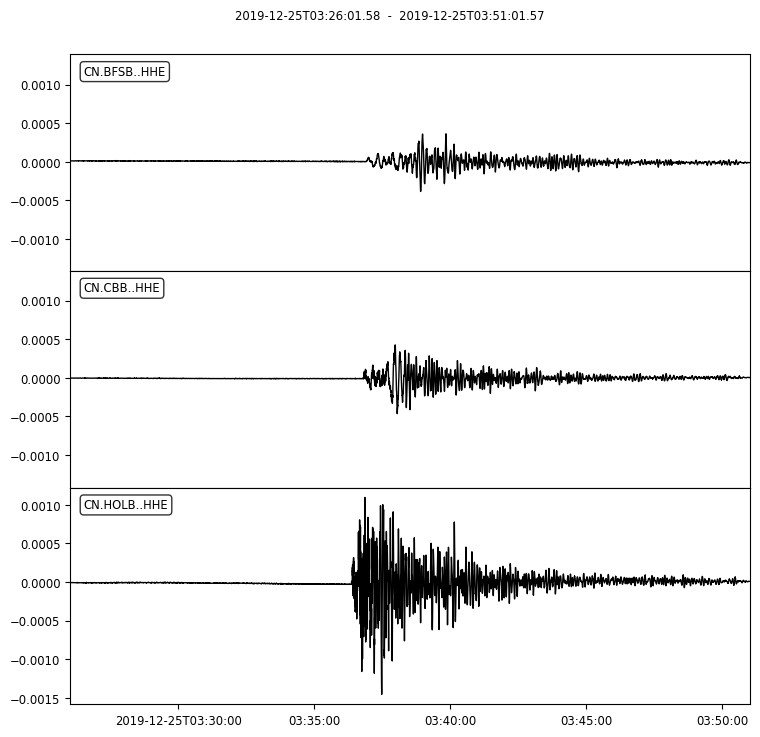

In [8]:
# View Streams
op = obj.stream.plot()

In [26]:
print(obj.stream)

3 Trace(s) in Stream:
CN.BFSB..HHE | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:51:01.570000Z | 100.0 Hz, 150000 samples
CN.CBB..HHE  | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:51:01.570000Z | 100.0 Hz, 150000 samples
CN.HOLB..HHE | 2019-12-25T03:26:01.580000Z - 2019-12-25T03:51:01.570000Z | 100.0 Hz, 150000 samples


In [9]:
# Set Up Dataloader
proto_batch_size = 20
train_loader = DataLoader(obj,batch_size=proto_batch_size,shuffle=False)

In [10]:
'''
#feat, lab = next(iter(train_loader))
print(feat.shape)
print(lab.shape)
'''

'\n#feat, lab = next(iter(train_loader))\nprint(feat.shape)\nprint(lab.shape)\n'

In [11]:
# Set Up CUDA
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    
obj.data = obj.data.to(device)
obj.labels = obj.labels.to(device)

In [12]:
print(obj.data.device)
print(obj.labels.device)

cuda:0
cuda:0


In [13]:
# Set Up Model
gcn_true = True
build_adj = True
dropout = 0.3
subgraph_size = 3
gcn_depth = 2
num_nodes = obj.num_nodes # Important
node_dim = 1 # Need to verify from Paper
dilation_exponential = 1
conv_channels = 32
residual_channels = 32
skip_channels = 64
end_channels = 128
in_dim = obj.ip_dim # Important
seq_in_len = obj.seq_length-1 # Important # seq-len bug to be adressed
seq_out_len = 1
layers = 3
batch_size = proto_batch_size # Set by Data Loader
propalpha = 0.05
tanhalpha = 3
num_split = 1
kernel_size = 7
kernel_set = [2, 3, 6, 7]

In [14]:
model = MTGNN(gcn_true=gcn_true, build_adj=build_adj, gcn_depth=gcn_depth, num_nodes=num_nodes,
                kernel_size=kernel_size, kernel_set=kernel_set, dropout=dropout, subgraph_size=subgraph_size,
                node_dim=node_dim, dilation_exponential=dilation_exponential,
                conv_channels=conv_channels, residual_channels=residual_channels,
                skip_channels=skip_channels, end_channels=end_channels,
                seq_length=seq_in_len, in_dim=in_dim, out_dim=seq_out_len,
                layers=layers, propalpha=propalpha, tanhalpha=tanhalpha, layer_norm_affline=True)
#model.double()
model.to(device)

MTGNN(
  (_mtgnn_layers): ModuleList(
    (0): MTGNNLayer(
      (_filter_conv): DilatedInception(
        (_time_conv): ModuleList(
          (0): Conv2d(32, 8, kernel_size=(1, 2), stride=(1, 1))
          (1): Conv2d(32, 8, kernel_size=(1, 3), stride=(1, 1))
          (2): Conv2d(32, 8, kernel_size=(1, 6), stride=(1, 1))
          (3): Conv2d(32, 8, kernel_size=(1, 7), stride=(1, 1))
        )
      )
      (_gate_conv): DilatedInception(
        (_time_conv): ModuleList(
          (0): Conv2d(32, 8, kernel_size=(1, 2), stride=(1, 1))
          (1): Conv2d(32, 8, kernel_size=(1, 3), stride=(1, 1))
          (2): Conv2d(32, 8, kernel_size=(1, 6), stride=(1, 1))
          (3): Conv2d(32, 8, kernel_size=(1, 7), stride=(1, 1))
        )
      )
      (_residual_conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
      (_skip_conv): Conv2d(32, 64, kernel_size=(1, 94), stride=(1, 1))
      (_mixprop_conv1): MixProp(
        (_mlp): Linear(
          (_mlp): Conv2d(96, 32, kernel_size=

In [15]:
# Train Param
criterion = nn.MSELoss(size_average=False)
evaluateL2 = nn.MSELoss(size_average=False)
evaluateL1 = nn.L1Loss(size_average=False)
optimizer = torch.optim.Adam(model.parameters(),lr=0.01)

D:\Development\Anaconda\envs\torch-spatio-temporal\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


In [16]:
# Train Loop
losses = list()
epochs = 1
model.train() # Train Mode
for e in tqdm(range(epochs)):
    for bid, samp in tqdm(enumerate(train_loader)):
        model.zero_grad()
#        if bid == 1:
#           break
        x = samp[0]
        y = torch.unsqueeze(samp[1],3) # or squeeze op
        # cuda stuff goes here
        op = model(x.float())
        loss = criterion(op,y.float())
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

  0%|          | 0/1 [00:00<?, ?it/s]

0it [00:00, ?it/s]

In [17]:
print(losses)

[4.83596658706665, 248925.140625, 0.5420795679092407, 1121.8349609375, 31.444896697998047, 7205.40380859375, 442.79864501953125, 2361.373779296875, 1380.504638671875, 111.9915542602539, 407.2618713378906, 333.457763671875, 80.36581420898438, 417.29779052734375, 78.91785430908203, 136.85556030273438, 257.3548583984375, 15.250072479248047, 106.70030212402344, 114.12049865722656, 9.786481857299805, 25.739164352416992, 54.646331787109375, 9.310968399047852, 14.212934494018555, 3.837695598602295, 12.651796340942383, 7.96734619140625, 3.5887250900268555, 16.568981170654297, 3.4982800483703613, 4.644124984741211, 11.275076866149902, 0.7593486309051514, 7.6773762702941895, 6.535393714904785, 0.695162832736969, 6.934618949890137, 2.590709924697876, 1.914999008178711, 5.360204696655273, 0.5862506031990051, 2.603302240371704, 3.40140700340271, 0.29517894983291626, 3.2892637252807617, 1.357616901397705, 0.7341628670692444, 2.1347999572753906, 0.5722829103469849, 1.239607810974121, 1.51343381404876

In [18]:
len(losses)

7495

In [19]:
import matplotlib.pyplot as plt

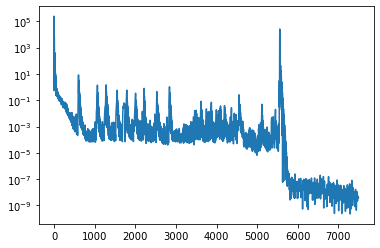

In [21]:
plt.figure()
plt.plot(losses)
plt.yscale('log')
plt.show()

In [24]:
adj = model._graph_constructor(model._idx.to(device)).detach().cpu().numpy()
print(adj)

[[ 0.          0.9999354   0.99998695]
 [ 0.          0.          0.6656943 ]
 [ 0.          0.          0.        ]]


In [ ]:
op

In [ ]:
# Eval Loop
test_loader = DataLoader(obj,batch_size=40,shuffle=False)
loss_eval = list()
op_eval = list()
model.eval()
for e in tqdm(range(epochs)):
    for bid, samp in tqdm(enumerate(test_loader)):
#        if bid == 1:
#           break
        x = samp[0]
        # cuda stuff goes here
        op = model(x.float())
        op_eval.append(op.detach().cpu())
        y = torch.unsqueeze(samp[1],3) # or squeeze op
        loss = criterion(op,y.float())
        loss_eval.append(loss.item())
        del loss

In [36]:
type(adj)

numpy.ndarray

NameError: name 'np' is not defined

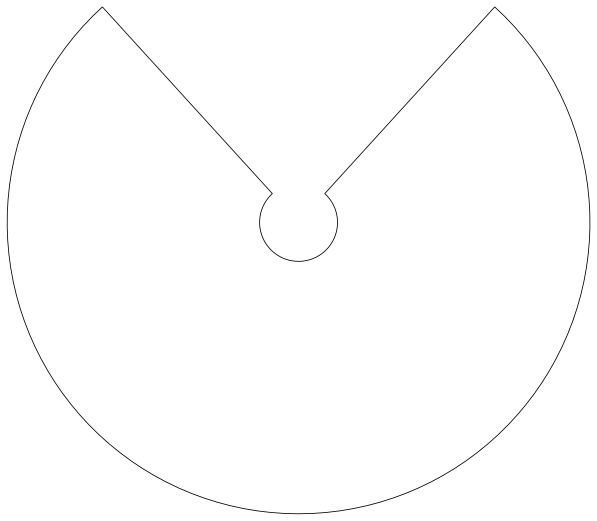

In [35]:
from est_lib.util.obspy_plot import ray_plot
import numpy as np
# Plot
lat = 50.6081
lon = -129.9656
ray_plot(
    ev_lat=lat,
    ev_lon=lon,
    min_lat=47.8,
    max_lat=52.,
    min_lon=-130.5,
    max_lon=-121,
    streams=obj.stream,
    inventory=obj.inv)